In [ ]:
import tensorflow as tf
import os
import sys
import numpy as np
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow
from skimage.transform import resize
import random
import matplotlib.pyplot as plt
import time
import tensorflow_hub as hub
#from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip /content/image_mask_100.zip

In [ ]:
#!unzip /content/cropped_img_msk.zip

resizing training images and masks


100%|██████████| 90/90 [02:35<00:00,  1.72s/it]


Done!


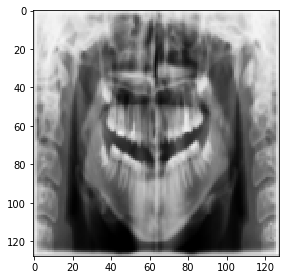

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


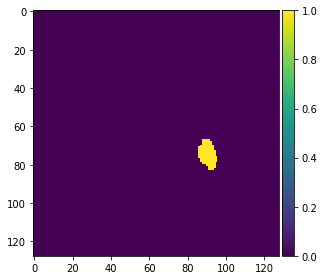

In [ ]:
#pre-processing and check all images and masks correctly read
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1
 
DATA_PATH = '/content/drive/MyDrive/Colab_Notebooks/GP/image_mask_100/Images/' # Training original images
Mask_path1= '/content/drive/MyDrive/Colab_Notebooks/GP/image_mask_100/seg1/'   # Segmentation Map
#Mask_path2= ''

seed = 42
random.seed = seed
np.random.seed = seed
 
image_ids = next(os.walk(DATA_PATH))[2]

len(image_ids)
X = np.zeros((len(image_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
Y = np.zeros((len(image_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('resizing training images and masks')
for n, id_ in tqdm(enumerate(image_ids), total=len(image_ids)):
  try:
    path = DATA_PATH 
    img = imread(path+ id_)[:,:]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(Mask_path1))[2]:
      if mask_file==id_:
        #print(Mask_path1 +  mask_file)
        mask_ = imread(Mask_path1 + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)

#-- start Second mask part --#
    #for mask_file in next(os.walk(Mask_path2))[2]:
      #if mask_file==id_:
        #print(Mask_path2 +  mask_file)
        #mask_ = imread(Mask_path2 + mask_file)
        #mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      #preserve_range=True), axis=-1)
        #mask = np.maximum(mask, mask_)
#-- end second mask part --#

    Y[n] = mask
  except:
    print('error')

x_train=X 
y_train=Y

print('Done!')

image_x = random.randint(0, len(image_ids)-1)#i added -1 temp
imshow(x_train[image_x])
plt.show()
imshow(np.squeeze(y_train[image_x]))
plt.show()

In [ ]:
#!unzip test_images.zip

In [ ]:
#test images
TEST_PATH = '/content/drive/MyDrive/Colab_Notebooks/GP/test_images/test/'

test_ids = next(os.walk(TEST_PATH))[2]

len(test_ids)
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)

sizes_test=[]
print('resizing training images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
  path = TEST_PATH 
  img = imread(path+ id_)[:,:]
  sizes_test.append([img.shape[0],img.shape[1]])
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
  X_test[n]=img 

#X_test=X 
#y_test=Y

resizing training images


100%|██████████| 100/100 [00:49<00:00,  2.04it/s]


#Model

In [ ]:
#Build U-Net model
#my input layer
#IMG_CHANNELS=1
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
#contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
 
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c5)
#expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [ ]:
#Modelcheckpoint-> save model after every epoch
#save_best_only -> the latest best model will not be overwritten 
checkpointer = tf.keras.callbacks.ModelCheckpoint('/content/model_for_tmolar.h5', verbose=1, save_best_only=True)
callbacks= [
            tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
            tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model.fit(x_train,y_train, validation_split=0.1, batch_size=1, epochs=50, callbacks=callbacks)

Epoch 1/50
81/81 [==============================] - 22s 242ms/step - loss: 0.0613 - accuracy: 0.9805 - val_loss: 0.0195 - val_accuracy: 0.9923
Epoch 2/50
81/81 [==============================] - 19s 240ms/step - loss: 0.0214 - accuracy: 0.9920 - val_loss: 0.0313 - val_accuracy: 0.9860
Epoch 3/50
81/81 [==============================] - 20s 246ms/step - loss: 0.0171 - accuracy: 0.9924 - val_loss: 0.0154 - val_accuracy: 0.9933
Epoch 4/50
81/81 [==============================] - 20s 246ms/step - loss: 0.0144 - accuracy: 0.9941 - val_loss: 0.0152 - val_accuracy: 0.9933
Epoch 5/50
81/81 [==============================] - 19s 238ms/step - loss: 0.0135 - accuracy: 0.9942 - val_loss: 0.0186 - val_accuracy: 0.9911
Epoch 6/50
81/81 [==============================] - 20s 241ms/step - loss: 0.0119 - accuracy: 0.9950 - val_loss: 0.0161 - val_accuracy: 0.9935
Epoch 7/50
81/81 [==============================] - 20s 248ms/step - loss: 0.0102 - accuracy: 0.9957 - val_loss: 0.0143 - val_accuracy: 0.9956

In [ ]:
#Save weights only
model.save_weights('/content/model_weights.h5')

In [ ]:
#Save model
t = time.time()
my_keras_model_filepath = '/content/saved_model.h5'.format(int(t))
print(my_keras_model_filepath)
model.save(my_keras_model_filepath)

/content/saved_model.h5


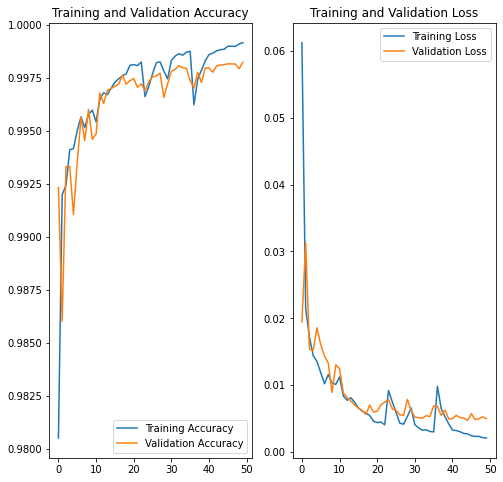

In [ ]:
import matplotlib.pyplot as plt
training_loss=results.history['loss']
training_accuracy=results.history['accuracy']
validation_loss=results.history['val_loss']
validation_accuracy=results.history['val_accuracy']
'''
#epochs=range(len(acc))
#plt.plot(epochs,training_accuracy,'r',label='Tranining accuracy')
#plt.plot(epochs,validation_accuracy,'b',label='Validation accuracy')
#plt.title('Tranining and Validation accuracy')
#plt.legend(loc=0)
#plt.figure()
#plt.show()
'''
epochs_range=range(len(training_accuracy))
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#to remove
'''
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
 
# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)
 
callbacks = [
  tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
  tf.keras.callbacks.TensorBoard(log_dir='./logs'),
  cp_callback 
]
 
results = model.fit(x_train, y_train, validation_split=0.1, batch_size=1, epochs=30, callbacks=callbacks)
'''

In [ ]:
#to remove
'''
from skimage.transform import resize
import random
import matplotlib.pyplot as plt

idx = random.randint(0, len(x_train)-1)
x=np.array(x_train[idx])
x=np.expand_dims(x, axis=0)
predict = model.predict(x, verbose=1)
 
predict = (predict > 0.5).astype(np.uint8)
 
imshow(np.squeeze(predict[0]))
plt.show()
 
imshow(x_train[idx])
 
plt.show()
'''

In [ ]:
idx = random.randint(0, len(x_train))
preds_train = model.predict(x_train[:int(x_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(x_train[int(x_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

4/4 [==============================] - 4s 950ms/step


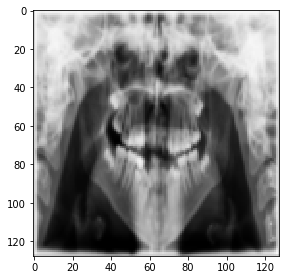

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


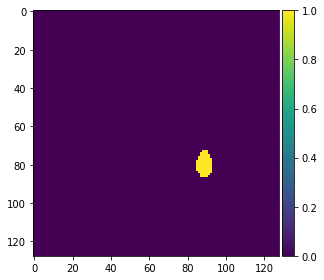

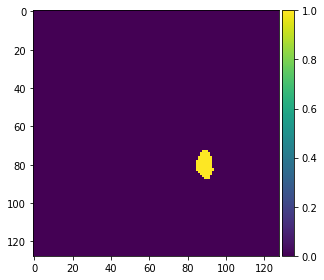

In [ ]:
ix = random.randint(0, len(preds_train_t))
imshow(x_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

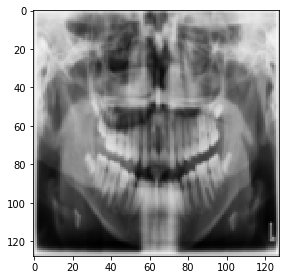

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


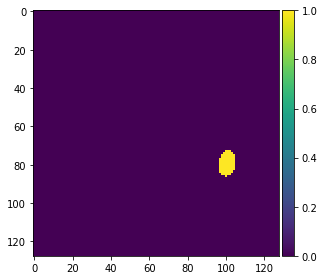

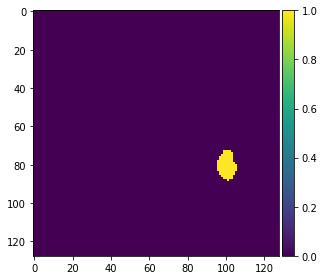

In [ ]:
ix = random.randint(0, len(preds_val_t))
imshow(x_train[int(x_train.shape[0]*0.9):][ix]-1)
plt.show()
imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

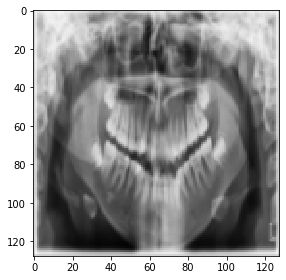

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


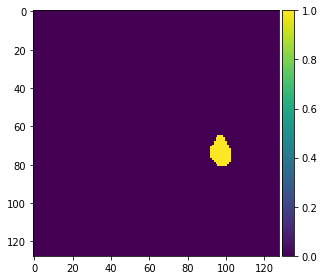

In [ ]:
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()

In [ ]:
#load saved model
model = tf.keras.models.load_model('/content/model5.h5', custom_objects={'KerasLayer': hub.KerasLayer})
model.summary()

In [ ]:
#to remove
'''
from skimage.transform import resize
import random
import matplotlib.pyplot as plt

idx = -1#random.randint(0, len(x_train)-1)
x=np.array(x_train[idx])
x=np.expand_dims(x, axis=0)
predict = model.predict(x, verbose=1)
 
predict = (predict > 0.5).astype(np.uint8)
 
imshow(np.squeeze(predict[0]))
plt.show()
 
imshow(x_train[idx])
 
plt.show()
'''

In [ ]:
#test U-net useful ref https://pallawi-ds.medium.com/semantic-segmentation-with-u-net-train-and-test-on-your-custom-data-in-keras-39e4f972ec89

#Finding Third Molar Length 

In [ ]:
!pip3 install imutils


In [ ]:
import cv2
import imutils
import imutils.perspective as persp
import scipy.spatial.distance as dist
import matplotlib.pyplot as plt
import numpy as np
import os


In [ ]:
img_path='/content/'
os.chdir(img_path)
img=cv2.imread("/content/m78_m.jpg")
rgb_img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,15))
#plt.imshow(rgb_img)
#plt.show()

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

In [ ]:
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
rgb_img=cv2.cvtColor(gray,cv2.COLOR_BGR2RGB)
#plt.imshow(rgb_img)

In [ ]:
thresh,thresh_img=cv2.threshold(gray,110,255,cv2.THRESH_BINARY)
rgb_img=cv2.cvtColor(thresh_img,cv2.COLOR_BGR2RGB)
#plt.imshow(rgb_img)

In [ ]:
conts=cv2.findContours(thresh_img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
print("total conturs", len(conts))
conts= imutils.grab_contours(conts)
print("total conturs", len(conts))

total conturs 2
total conturs 1


In [ ]:
cont_img=np.zeros(img.shape)
#plt.imshow(cont_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


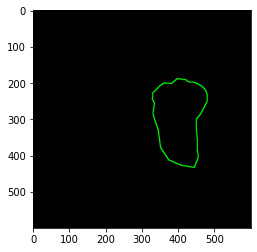

In [ ]:
cont_img=cv2.drawContours(cont_img,conts,-1,(0,255,0),2)
plt.imshow(cont_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


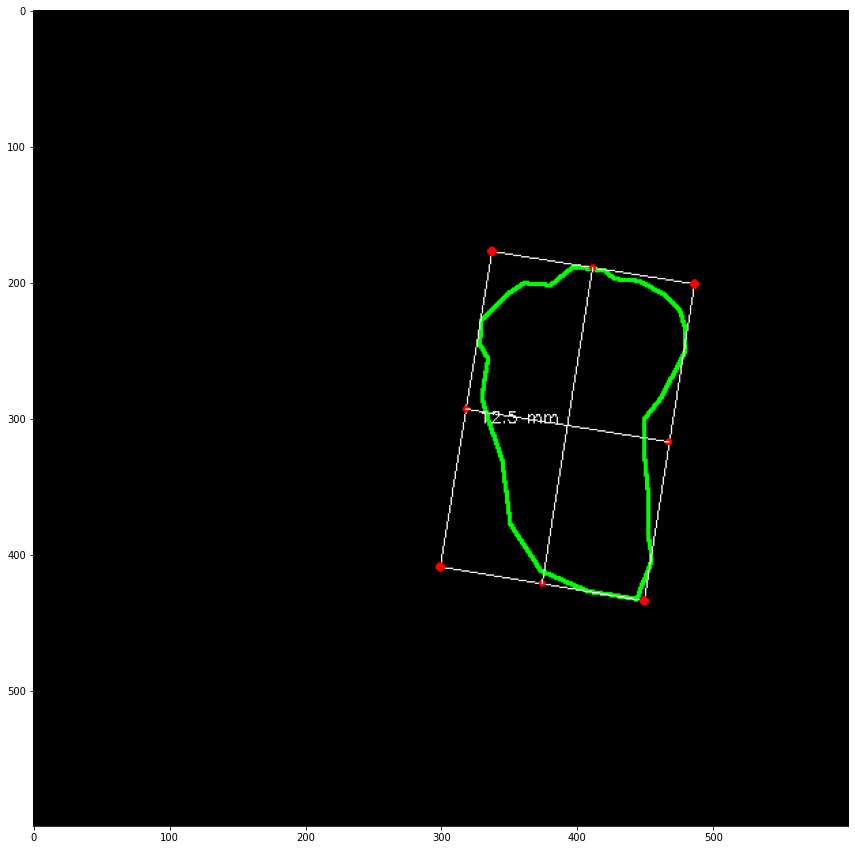

In [ ]:
cont_img=np.zeros(img.shape)
def midPoint(ptA,ptB):
  return ((ptA[0]+ptB[0])/2, (ptA[1]+ptB[1])/2)

for c in conts:
  box=cv2.minAreaRect(c)
  #print(box)
  box=cv2.boxPoints(box)
  box=np.array(box,dtype='int')

  if cv2.contourArea(c) < 900:
    continue

  cv2.drawContours(cont_img,[c],-1,(0,255,0),2)
  cv2.drawContours(cont_img,[box],-1,(255,255,255),1)

  #print(box)

  for (x,y) in box:
    #print(x,y)
    cv2.circle(cont_img,(x,y),2,(255,0,0),2)
    (tl,tr,br,bl)=box
#rigth-left
    (tlX,trX)= midPoint(tl,tr)
    (brX,blX)= midPoint(br,bl)

    cv2.circle(cont_img,(int(tlX),int(trX)),1,(255,0,0),2)
    cv2.circle(cont_img,(int(brX),int(blX)),1,(255,0,0),2) 
 #connect mid points using line 
    cv2.line(cont_img,(int(tlX),int(trX)),(int(brX),int(blX)),(255,255,255),1)   

    #calculate the distance on the midpoints

dA=dist.euclidean((tlX,trX),(brX,blX))

#cv2.putText(cont_img, "{:.1f} mm".format(dA*0.08221083073205848),(int(tlX-10),int(trX-10)), cv2.FONT_HERSHEY_SIMPLEX,0.4,(255,255,255),1)
#top-bottom
(tlX,trX)= midPoint(tl, bl)
(brX,blX)= midPoint(tr,br)

cv2.circle(cont_img,(int(tlX),int(trX)),1,(255,0,0),2)
cv2.circle(cont_img,(int(brX),int(blX)),1,(255,0,0),2) 

 #connect mid points using line 
cv2.line(cont_img,(int(tlX),int(trX)),(int(brX),int(blX)),(255,255,255),1)


#calculate the distance on the midpoints

dB=dist.euclidean((tlX,trX),(brX,blX))

#print size on pix on each conture rectangel 

cv2.putText(cont_img, "{:.1f} mm".format(dB*0.08221083073205848),(int(brX+10),int(blX+10)), cv2.FONT_HERSHEY_SIMPLEX,0.4,(255,255,255),1)


plt.figure(figsize=(15,15))
plt.imshow(cont_img)
plt.show()


Ref:


*   https://stackoverflow.com/questions/10989005/do-i-understand-os-walk-right

*   https://www.youtube.com/watch?v=68HR_eyzk00&t=938s 
*   https://www.youtube.com/watch?v=RaswBvMnFxk


*   https://github.com/bnsreenu/python_for_microscopists/blob/master/074-Defining%20U-net%20in%20Python%20using%20Keras.py
* https://www.youtube.com/watch?v=kaE7jQqIFI8




